In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
data=pd.read_csv(r"C:\Users\JOHAN\Desktop\vgsales.csv",parse_dates=True,index_col='Rank')

In [3]:
data.head(5)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16600
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16598 non-null  object 
 1   Platform      16598 non-null  object 
 2   Year          16327 non-null  float64
 3   Genre         16598 non-null  object 
 4   Publisher     16540 non-null  object 
 5   NA_Sales      16598 non-null  float64
 6   EU_Sales      16598 non-null  float64
 7   JP_Sales      16598 non-null  float64
 8   Other_Sales   16598 non-null  float64
 9   Global_Sales  16598 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.4+ MB


In [5]:
def search_categorical(data,columns):
    datos={'column':[],'cantidad':[],'valores':[]}
    for col in columns:
        valor=data[col].value_counts()
        datos['column'].append(col)
        datos['cantidad'].append(len(valor))
        datos['valores'].append(';'.join([str(element) for element in valor.index]))
    return pd.DataFrame(datos)

In [6]:
column_text=['Name','Platform','Genre','Publisher']
search_categorical(data,column_text)

,column,cantidad,valores
0,Name,11493,Need for Speed: Most Wanted;Ratatouille;FIFA 1...
1,Platform,31,DS;PS2;PS3;Wii;X360;PSP;PS;PC;XB;GBA;GC;3DS;PS...
2,Genre,12,Action;Sports;Misc;Role-Playing;Shooter;Advent...
3,Publisher,578,Electronic Arts;Activision;Namco Bandai Games;...


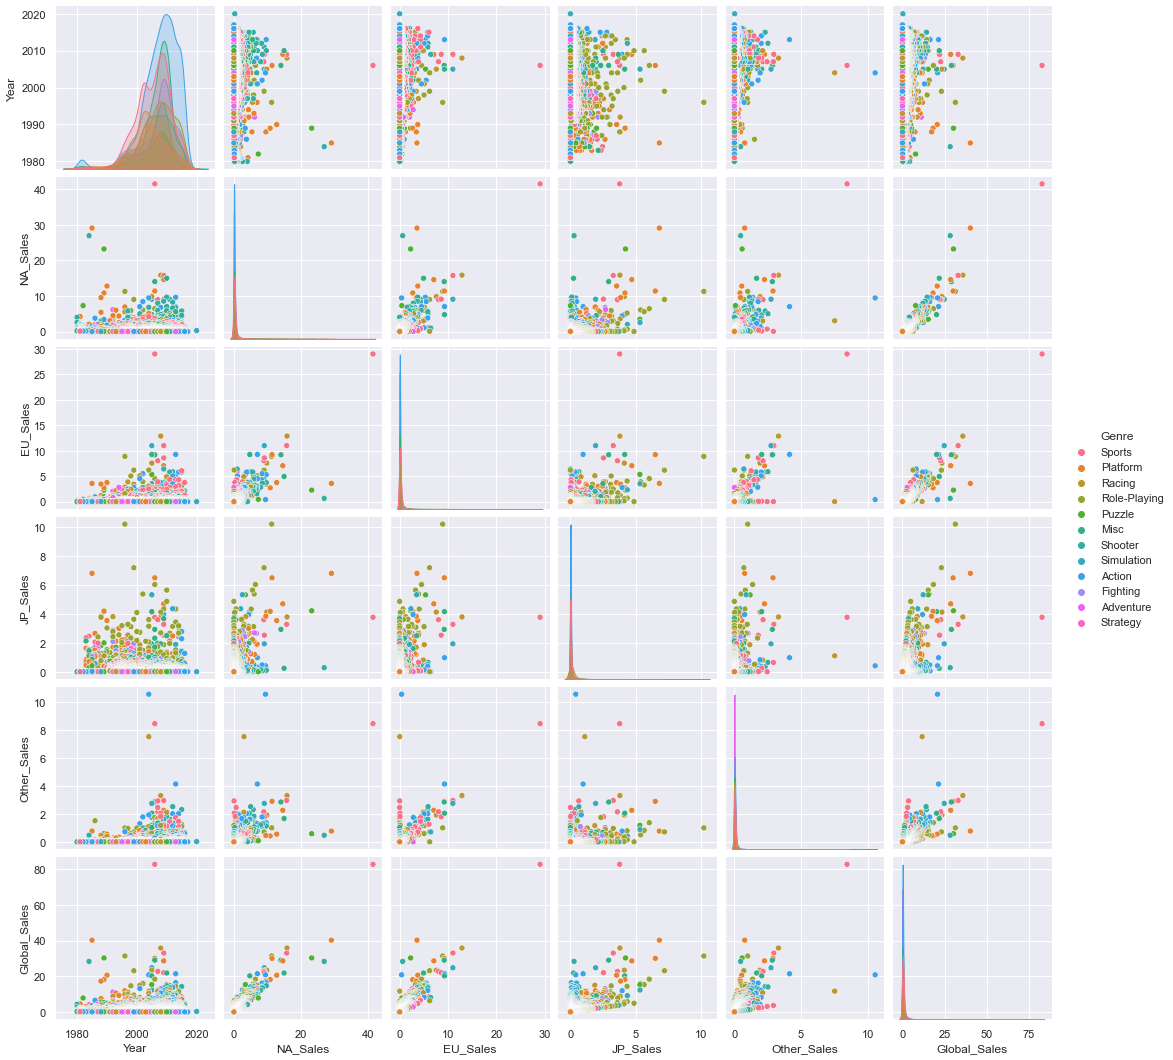

In [7]:
##ahora observamos la distribucion de los datos continuos
sns.pairplot(data,hue='Genre')


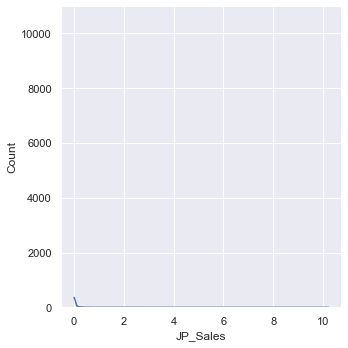

In [16]:
columns_numeros=['Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']
sns.displot(data['JP_Sales'],kde=True)

<AxesSubplot:>

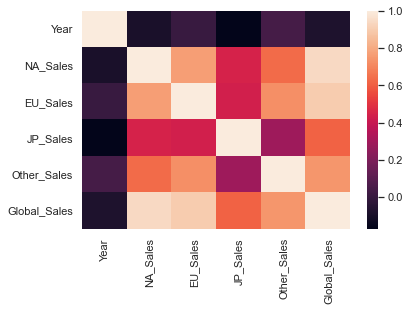

In [9]:
#averiguemos la correlacion de los datos
sns.heatmap(data.corr(method='pearson'))

In [20]:
#exploramos los datos faltantes
data.isnull().sum(axis=0)

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [19]:
##PREPARACION DE LOS DATOS
#rellenar valores faltantes
data['Year']=data['Year'].fillna(data['Year'].mode()[0])
data['Publisher']=data['Publisher'].fillna(data['Publisher'].mode()[0])

In [24]:
data=data[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Genre']]

In [28]:
data.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Genre
Rank,,,,,
1,41.49,29.02,3.77,8.46,10
2,29.08,3.58,6.81,0.77,4
3,15.85,12.88,3.79,3.31,6
4,15.75,11.01,3.28,2.96,10
5,11.27,8.89,10.22,1.00,7


In [27]:
#realizamos la codificacion de datos
from sklearn.preprocessing import LabelEncoder,StandardScaler
encoder=LabelEncoder()
data['Genre']=encoder.fit_transform(data['Genre'])

In [29]:
X=data.drop('Genre',axis=1).values
y=data['Genre'].values
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True,stratify=y)

In [31]:
#eleccion general del modelo
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(class_weight='balanced')
model.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [33]:
model.score(x_test,y_test)*100

17.730923694779115

In [34]:
model.score(x_train,y_train)

0.500086073334481

In [50]:
#hacemos una evaluacion de hiperparametros con pipelines
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.pipeline import Pipeline
def model_tunning_parameters():
    model=RandomForestClassifier(class_weight='balanced',n_estimators=300)
    cv=StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
    pipe_model=Pipeline(steps=[
        ('scaler',StandardScaler()),
        ('forest',model)
    ])
    grid= GridSearchCV(pipe_model,
                      param_grid=dict(
                          forest__max_depth=range(8,20)
                        ),
                       cv=cv,
                       scoring='accuracy',
                       n_jobs=-1,
                       verbose=1,
                       return_train_score=True
                      )
    return grid
    

In [51]:
grid=model_tunning_parameters()

In [52]:
grid.fit(x_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=300))]),
             n_jobs=-1, param_grid={'forest__max_depth': range(8, 20)},
             return_train_score=True, scoring='accuracy', verbose=1)

In [53]:
grid.best_score_

0.19487051194812471

In [54]:
grid.best_params_

{'forest__max_depth': 12}

In [56]:
model=grid.best_estimator_

In [58]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,3.802704,0.128141,0.206641,0.037731,8,{'forest__max_depth': 8},0.174699,0.190189,0.173838,0.178141,...,0.246557,0.249139,0.250000,0.258416,0.258129,0.255643,0.249211,0.248255,0.252109,0.004045
1,4.369552,0.107464,0.265142,0.034768,9,{'forest__max_depth': 9},0.186747,0.189329,0.172117,0.186747,...,0.288160,0.285482,0.286725,0.293324,0.288064,0.294759,0.283638,0.288132,0.288432,0.003237
2,5.389389,0.442676,0.218101,0.031126,10,{'forest__max_depth': 10},0.196213,0.203098,0.175559,0.193632,...,0.331867,0.331006,0.329763,0.331771,0.329285,0.334640,0.328201,0.327149,0.330636,0.002150
3,5.416497,0.402943,0.239104,0.022149,11,{'forest__max_depth': 11},0.203959,0.199656,0.182444,0.201377,...,0.372418,0.373948,0.368879,0.376148,0.373852,0.377200,0.370087,0.377068,0.374266,0.002882
4,5.983046,0.278019,0.261579,0.031192,12,{'forest__max_depth': 12},0.199656,0.201377,0.177281,0.196213,...,0.411821,0.415933,0.410673,0.417846,0.414499,0.418229,0.411208,0.410634,0.414749,0.003462
5,5.576192,0.271027,0.213468,0.014059,13,{'forest__max_depth': 13},0.196213,0.197935,0.173838,0.192771,...,0.446538,0.449216,0.446155,0.453233,0.444625,0.450363,0.447069,0.446782,0.448260,0.002451
6,5.910939,0.259211,0.256587,0.028955,14,{'forest__max_depth': 14},0.195353,0.197935,0.181583,0.178141,...,0.474943,0.476282,0.472265,0.476568,0.468344,0.477142,0.472698,0.473367,0.474312,0.002547
7,6.100635,0.256003,0.239751,0.018915,15,{'forest__max_depth': 15},0.200516,0.202238,0.178141,0.174699,...,0.489671,0.490819,0.489671,0.490149,0.487280,0.492062,0.489529,0.485034,0.489824,0.002132
8,6.289527,0.354047,0.274477,0.037446,16,{'forest__max_depth': 16},0.199656,0.197935,0.182444,0.174699,...,0.498852,0.501052,0.499426,0.500287,0.495792,0.499044,0.497275,0.496605,0.498556,0.001555
9,6.605349,0.204422,0.278046,0.024216,17,{'forest__max_depth': 17},0.204819,0.196213,0.186747,0.168675,...,0.504878,0.504591,0.502869,0.503347,0.501721,0.504017,0.502056,0.502534,0.503003,0.001106


In [59]:
from sklearn.metrics import classification_report

In [60]:
y_pred=model.predict(x_test)
report=classification_report(y_test,y_pred)

In [61]:
print(report)

              precision    recall  f1-score   support

           0       0.32      0.14      0.20       995
           1       0.26      0.35      0.30       386
           2       0.08      0.08      0.08       254
           3       0.23      0.07      0.11       522
           4       0.13      0.26      0.17       266
           5       0.10      0.28      0.14       175
           6       0.15      0.19      0.17       375
           7       0.24      0.27      0.26       446
           8       0.18      0.20      0.19       393
           9       0.11      0.11      0.11       260
          10       0.35      0.20      0.26       704
          11       0.12      0.25      0.16       204

    accuracy                           0.19      4980
   macro avg       0.19      0.20      0.18      4980
weighted avg       0.23      0.19      0.19      4980



<AxesSubplot:>

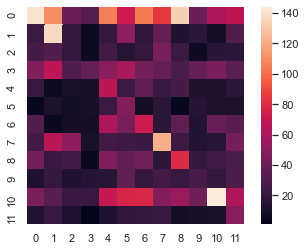

In [65]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(y_test,y_pred)
sns.heatmap(conf,fmt='0.2f',square=True)

In [66]:
import joblib
joblib.dump(model,'model_predict_genre.pkl')

['model_predict_genre.pkl']